### TTopt for RL
This is a minimalistic example how to use **TTopt** for optimal  on-policy search in Reinforcement learning tasks. ## its recomened to run this particular example in Colab, otherwise docker or root access maybe needed to install mujoco https://github.com/openai/mujoco-py

In [1]:
import sys
import os
try:
  import colab
except:
  in_colab=False
try:
  import mujoco
except:
  !pip install matplotlib cma nevergrad pyproj teneva
  !pip install maxvolpy
  !pip install git+https://github.com/AndreiChertkov/ttopt
  !apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common
  !apt-get install -y patchelf
  !pip install free-mujoco-py
  !pip install mujoco
import matplotlib.pyplot as plt
params = {'text.usetex' : False,
          'font.size' : 42,
          'legend.fancybox':True,
          'legend.loc' : 'best',
          'legend.framealpha': 0.9,
          "legend.fontsize" : 25,
         }
plt.rcParams.update(params)
import mujoco_py
import mujoco
import copy
import numpy as np
import gym
from joblib import Parallel, delayed
import joblib
from ttopt import TTOpt
from ttopt import ttopt_init
from scipy.linalg import toeplitz
import multiprocessing

In [2]:
class Policy():
    def __init__(self,theta):
        self.theta = None
        self.is_discrete=False
        self.safe_softplus = lambda x: x * (x >= 0) + np.log1p(np.exp(-np.abs(x)))

    def __repr__(self):
        return self.policy_name

    def __str__(self):
        return self.policy_name

    def softmax(self, inputs,temperature=1.0):
        inputs = inputs - max(inputs)
        return relaxed_softmax(inputs,temperature,-1)

    def linear(self,inputs):
        return inputs

    def softplus(self,x):
        return self.safe_softplus(x)

    def tanh(self,inputs):
        return np.tanh(inputs)

    def relu(self,inputs):
        return inputs * (inputs > 0)

    def elu(self,inputs,alpha=1.0):
        z = inputs
        return np.where(z > 0, z,  alpha * (np.exp(z) - 1))

    def set_theta(self,theta):
        self.theta = theta

class ToeplitzPolicy(Policy):
    """
        Compact ToeplitzPolicy, adapted
        from https://github.com/jparkerholder/ASEBO/blob/master/asebo/policies.py
        Choromanski (2018)
        In fact this is simple CNN!
    """
    def __init__(self,theta,num_inputs,num_outputs,num_hidden,normalize_output=False,
                 bias = True,temperature=1.0,activation='tanh'):

        super(Policy,self).__init__()
        self.policy_name = 'ToeplitzPolicy'

        self.policy_params = {}
        self.policy_params['seed'] = 0
        self.policy_params['zeros'] = True
        self.policy_params['ob_dim'] = num_inputs
        self.policy_params['h_dim'] = num_hidden
        self.policy_params['ac_dim'] = num_outputs

        self.activation = activation
        self.temperature = temperature
        self.bias1 = 0
        self.bias2 = 0
        self.act = getattr(self,self.activation)
        self.normalize_output = normalize_output

        self.init_seed = self.policy_params['seed']
        self.ob_dim = self.policy_params['ob_dim']
        self.h_dim = self.policy_params['h_dim']
        self.ac_dim = self.policy_params['ac_dim']
        self.all_weight_init()

    def all_weight_init(self):
        self.w1 = self.weight_init(self.ob_dim + self.h_dim -1, self.policy_params['zeros'])
        self.w2 = self.weight_init(self.h_dim * 2 - 1, self.policy_params['zeros'])
        self.w3 = self.weight_init(self.ac_dim + self.h_dim - 1, self.policy_params['zeros'])

        self.W1 = self.build_layer(self.h_dim, self.ob_dim, self.w1)
        self.W2 = self.build_layer(self.h_dim, self.h_dim, self.w2)
        self.W3 = self.build_layer(self.ac_dim, self.h_dim, self.w3)

        self.b1 = self.weight_init(self.h_dim, self.policy_params['zeros'])
        self.b2 = self.weight_init(self.h_dim, self.policy_params['zeros'])
        self.theta = np.concatenate([self.w1, self.b1, self.w2, self.b2, self.w3])
        self.d = len(self.theta)

    def weight_init(self, d, zeros):

        if zeros:
            w = np.zeros(d)
        else:
            np.random.seed(self.init_seed)
            w = np.random.rand(d) / np.sqrt(d)
        return(w)

    def get_parametrs(self):
        return self.theta

    def build_layer(self, d1, d2, v):
        # len v = d1 + d2 - 1
        col = v[:d1]
        row = v[(d1-1):]

        W = toeplitz(col, row)
        return(W)

    def update(self, vec):

        self.w1 += vec[:len(self.w1)]
        vec = vec[len(self.w1):]

        self.b1 += vec[:len(self.b1)]
        vec = vec[len(self.b1):]

        self.w2 += vec[:len(self.w2)]
        vec = vec[len(self.w2):]

        self.b2 += vec[:len(self.b2)]
        vec = vec[len(self.b2):]

        self.w3 += vec

        self.W1 = self.build_layer(self.h_dim, self.ob_dim, self.w1)
        self.W2 = self.build_layer(self.h_dim, self.h_dim, self.w2)
        self.W3 = self.build_layer(self.ac_dim, self.h_dim, self.w3)

    def set_theta(self,theta):
        if theta is None:
            return
        self.all_weight_init()
        self.update(theta)
        self.theta = np.concatenate([self.w1, self.b1, self.w2, self.b2, self.w3])



    def __call__(self, X):
        h1 = np.dot(self.W1, X) + self.b1
        z1 = self.act(h1)
        h2 = np.dot(self.W2, z1) + self.b2
        z2 = self.act(h2)
        o = np.dot(self.W3, z2)
        if self.normalize_output:
            o = self.softmax(o,self.temperature)
        else:
            o = self.tanh(o)
        return o

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
 env_name='InvertedPendulum-v2'
 env = gym.make(env_name)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment InvertedPendulum-v2 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/envs/mujoco/mujoco_env.py:237: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: W

In [4]:
def J(theta=None,env_name='InvertedPendulum-v2',starting_seed=42,num_seeds=10,num_hidden=8):
  """
    staight forward openai gym style loop
  """
  env = gym.make(env_name)
  state = env.reset()
  rewards = []
  num_inputs,num_outputs = env.observation_space.shape[0],env.action_space.shape[0]
  policy = ToeplitzPolicy(None,num_inputs,num_outputs,num_hidden=num_hidden,activation='tanh')
  d = policy.d
  test = False
  if theta is None:
    test = True
    theta = np.ones(d)
  policy.set_theta(theta)
  seeds = np.arange(num_seeds).astype('int')
  for seed in seeds:
    seed = starting_seed + seed
    env = gym.make(env_name)
    state = env.reset(seed=int(seed))
    done=False
    sum_rewards=[]
    while not done:
        action = policy(state)
        state, reward, done, info = env.step(action)
        sum_rewards.append(reward)
    rewards.append(sum(sum_rewards))
  env.close()
  mean_rewards = np.mean(rewards)
  return (mean_rewards,d) if test else mean_rewards

In [5]:
def wrap(J):
    def wrappend_J(thetas,num_cores = None):
        """
        Since TTopt is search based optimizer it ask/tell for a batch of samples num_samples x numel(theta)
        """
        from joblib import Parallel, delayed
        import multiprocessing
        if num_cores is None:
          num_cores = multiprocessing.cpu_count()
        if len(thetas.shape) == 1:
            thetas = thetas[None]
        rewards=Parallel(n_jobs=num_cores)(delayed(J)(theta)  for theta in thetas)
        return np.array(rewards)
    return wrappend_J

In [6]:
wrappend_J=wrap(J)

In [7]:
sum_rewards,d=J()

In [8]:
np.random.seed(42)
rmax=2
# We initialize the TTOpt class instance with the correct parameters:
tto = TTOpt(
    f=wrappend_J,                    # Function for minimization. X is [samples, dim]
    d=d,                    # Number of function dimensions
    a=-1.,                 # Grid lower bound (number or list of len d)
    b=+1.,                 # Grid upper bound (number or list of len d)
    p=3,                    # The grid size factor (there will n=p^q points)
    q=1,                   # The grid size factor (there will n=p^q points)
    evals=2000,            # Number of function evaluations
    is_func=False,
    name='InvertedPendulum-v2',          # Function name for log (this is optional)
    with_log=True)

In [9]:
# And now we launching the minimizer:
tto.maximize(rmax)

InvertedPendulum-v2-50d | evals=1.80e+01 | t_cur=2.82e+00 | y= 4.000000e+00 
InvertedPendulum-v2-50d | evals=3.00e+01 | t_cur=4.46e+00 | y= 4.000000e+00 
InvertedPendulum-v2-50d | evals=4.20e+01 | t_cur=5.98e+00 | y= 4.000000e+00 
InvertedPendulum-v2-50d | evals=5.40e+01 | t_cur=6.96e+00 | y= 4.000000e+00 
InvertedPendulum-v2-50d | evals=6.60e+01 | t_cur=7.96e+00 | y= 4.000000e+00 
InvertedPendulum-v2-50d | evals=7.80e+01 | t_cur=8.96e+00 | y= 4.000000e+00 
InvertedPendulum-v2-50d | evals=9.00e+01 | t_cur=1.00e+01 | y= 4.400000e+00 
InvertedPendulum-v2-50d | evals=1.02e+02 | t_cur=1.12e+01 | y= 2.490000e+01 
InvertedPendulum-v2-50d | evals=1.14e+02 | t_cur=1.23e+01 | y= 2.490000e+01 
InvertedPendulum-v2-50d | evals=1.26e+02 | t_cur=1.35e+01 | y= 2.490000e+01 
InvertedPendulum-v2-50d | evals=1.38e+02 | t_cur=1.47e+01 | y= 2.490000e+01 
InvertedPendulum-v2-50d | evals=1.50e+02 | t_cur=1.54e+01 | y= 2.490000e+01 
InvertedPendulum-v2-50d | evals=1.62e+02 | t_cur=1.63e+01 | y= 2.490000e+01 

Text(0.5, 0, 'Rewards')

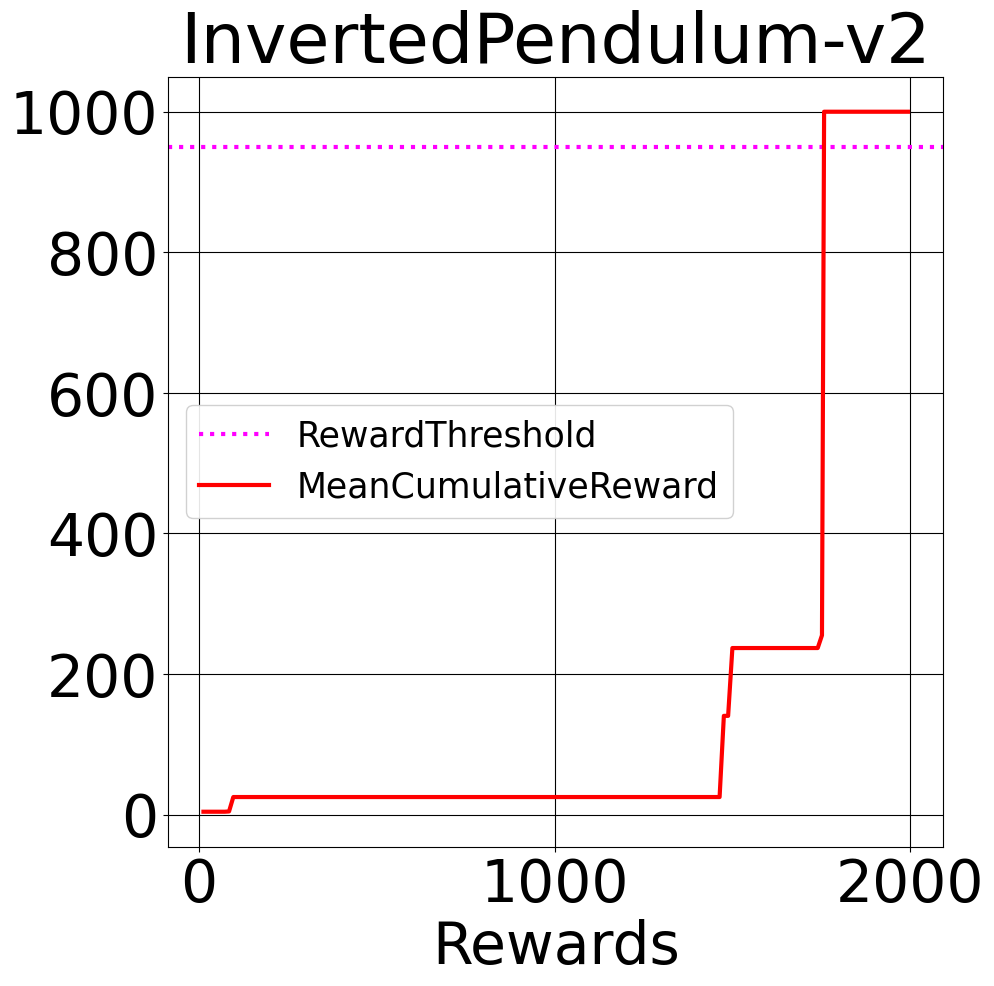

In [10]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.set_title(env_name)
ax.axhline(env.spec.reward_threshold,lw=3,color='magenta',ls=':',label='RewardThreshold')
ax.grid(color='black')
ax.plot(np.cumsum(tto.evals_min_list),np.array(tto.y_min_list),color='red',lw=3,label='MeanCumulativeReward')
ax.legend(loc='best')
ax.set_xlabel('Episodes')
ax.set_xlabel('Rewards')